In [32]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import cv2

import wfdb
import warnings

from assets.transformation_functions import SignalTransformer
from assets.graph_functions import plot_signal_data
from models.AnomalyDetector import AnomalyDetector

MODEL_PATH = "models/final_model.keras"
ANOMALY_PATH = "data/arrythmia_rates/"
NORMAL_PATH = "data/normal_rates/"

warnings.filterwarnings("ignore")


def load_full_ecg(path, id):
    record = wfdb.rdrecord(path + id)
    ann = wfdb.rdann(path + id, "atr")

    signal = record.p_signal[:, 0] # MLII
    ann_sample = ann.sample # annotation locations
    ann_symbol = ann.symbol # annotation symbols
    
    return signal, ann_sample, ann_symbol

IDX = 306

In [2]:
transformer = SignalTransformer()
model = AnomalyDetector(MODEL_PATH)

In [3]:
signal, annotations, symbols = load_full_ecg(NORMAL_PATH, "16539")

In [23]:
annotations[:30]

array([  72,  168,  268,  364,  454,  543,  636,  746,  866,  969, 1063,
       1155, 1249, 1346, 1453, 1562, 1672, 1770, 1869, 1970, 2077, 2180,
       2281, 2371, 2463, 2554, 2647, 2741, 2831, 2925], dtype=int64)

In [21]:
signal[:30]

array([-0.185, -0.155, -0.145, -0.135, -0.105, -0.095, -0.095, -0.065,
       -0.055, -0.025, -0.005,  0.025,  0.045,  0.075,  0.095,  0.105,
        0.105,  0.115,  0.105,  0.075,  0.045,  0.005, -0.045, -0.075,
       -0.105, -0.115, -0.125, -0.125, -0.125, -0.125])

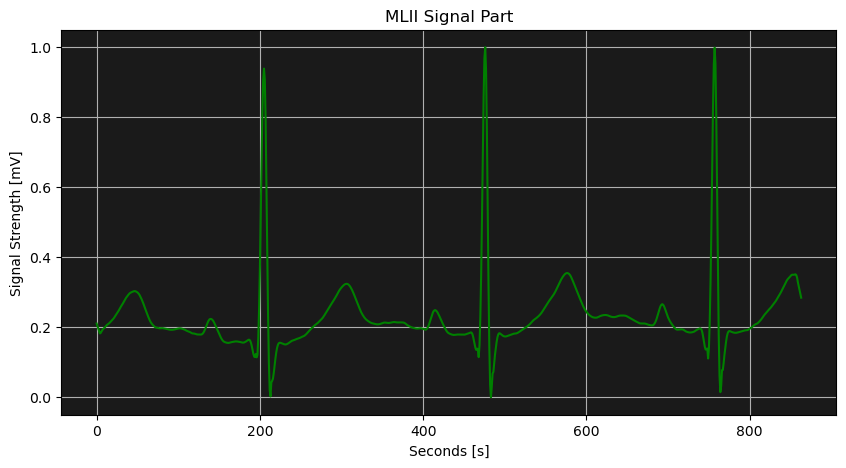

In [27]:
fig, ax = plt.subplots(figsize=(10,5))

for ii in range(10):
    plot_signal_data(ax, range(864), transformer.transform_signal(signal[ii:IDX+ii]))
    plt.pause(0.05)

plt.show()

In [37]:
window_size = 500
height, width = 400, 800 
scale_x = width / window_size
scale_y = height

frame = np.ones((height, width, 3), dtype=np.uint8) * 0  # 3 kanały dla BGR
ii = 0

signal_tt = transformer._normalize_signal(signal)

for i in range(1, len(signal_tt)):
    frame[:, :-int(scale_x)] = frame[:, int(scale_x):]
    frame[:, -int(scale_x):] = 0

    y1 = int(scale_y - signal_tt[i-1] * scale_y)
    y2 = int(scale_y - signal_tt[i] * scale_y)
    cv2.line(frame, (width - int(scale_x) - 1, y1), (width - 1, y2), (11, 212, 11), 1)


    if (i > 306 and i % 76 == 0) or (i == 306):
        x1_r = width - 306
        x2_r = width - 1
        #cv2.rectangle(ff, (x1_r, 50), (x2_r, 300), (0, 0, 255), 1)
        signal_window = transformer.transform_signal(signal[ii*864:(ii+1)*864])
        result = model.predict(signal_window)[0]
        print(result)
        ii += 1
        
        cv2.imshow("Current Signal Window", frame[:, -306:])

    cv2.imshow('ECG Live Plot', frame)
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break

cv2.destroyAllWindows()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1


In [60]:
sss = transformer.transform_signal(signal[17:306+17])
sig = model.predict(sss)[0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


In [62]:
def plot_between_signals(ax: mpl.axes.Axes, x: np.array, y1: np.array, y2: np.array, plot_kws={}):
    ax.fill_between(x, y1, y2, **plot_kws)

    return ax

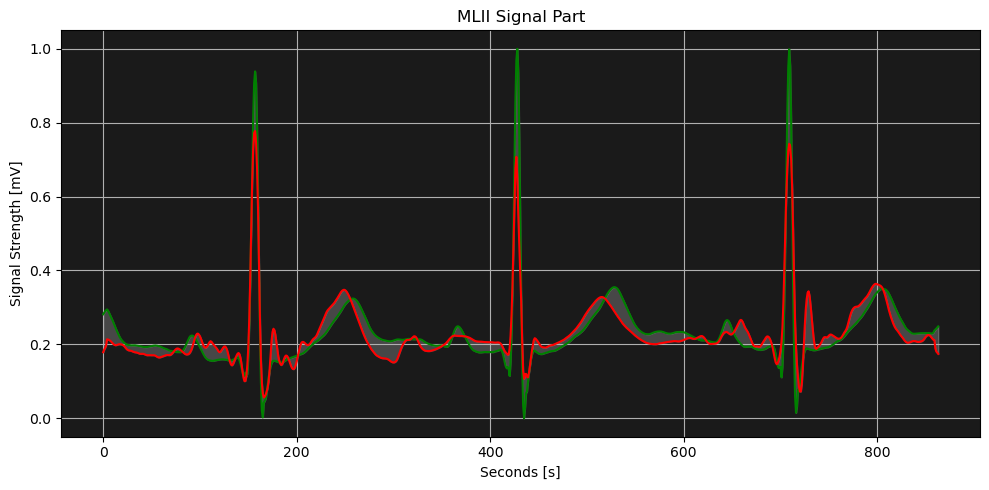

In [64]:
fig, ax = plt.subplots(figsize=(10,5))

plot_signal_data(ax, range(864), sss[:864])
plot_signal_data(ax, range(864), sig[0], plot_kws={"c": "red"})
plot_between_signals(ax, range(864), sss[:864], sig[0], plot_kws={"color": "white", "alpha": 0.2})

plt.grid()
plt.tight_layout()
plt.show()

In [66]:
np.mean(np.square(sss - sig), axis=1)

array([0.00228403])

In [129]:
np.argwhere(signal >= np.quantile(signal, 0.99)).shape

(115083, 1)

In [117]:
len(annotations)

108674

In [157]:
s_part = np.hstack([signal[169-int(128*1.2):169], signal[169:169+int(128*1.2)]])
ss = transformer.transform_signal(s_part)

np.argwhere(ss > 0.5).shape

(24, 1)

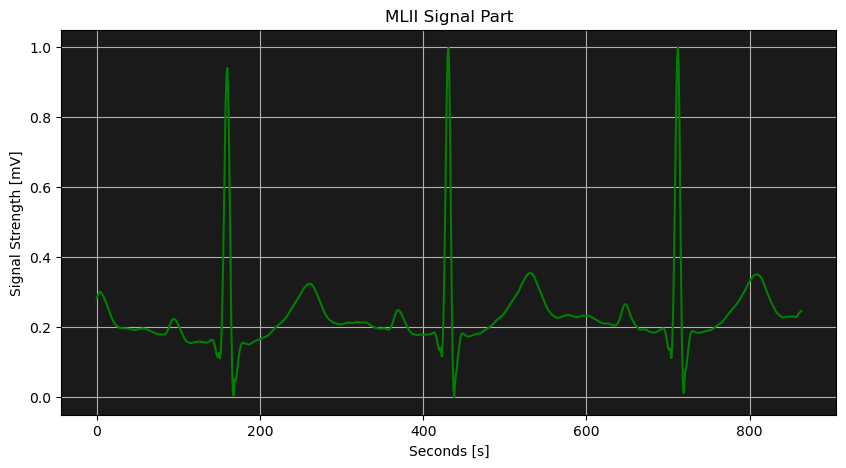

In [155]:
fig, ax = plt.subplots(figsize=(10,5))
plot_signal_data(ax, range(864), ss)
plt.show()